# Chapter 30: Examples 3

we’ve learned about sorting streams, graphs and plots, roman numerals, environment, post-tonal tools, iterators, grace notes, and spanners.

Now let’s put as many of these together as we can to **analyze music computationally**.

In [1]:
from music21 import *

## Let’s use these, which are called “ryansMammoth” in the corpus, for some examples

In [2]:
ryans = corpus.search('ryansMammoth')
ryans

<music21.metadata.bundles.MetadataBundle {1059 entries}>

In [3]:
# Let’s look at one of these that I know is called ‘Highland Regiment’
highland = ryans.search('Highland Regiment')
highland

<music21.metadata.bundles.MetadataBundle {1 entry}>

In [6]:
highlandParsed = highland[0].parse()
highlandParsed.measures(0, 8).show('xml')

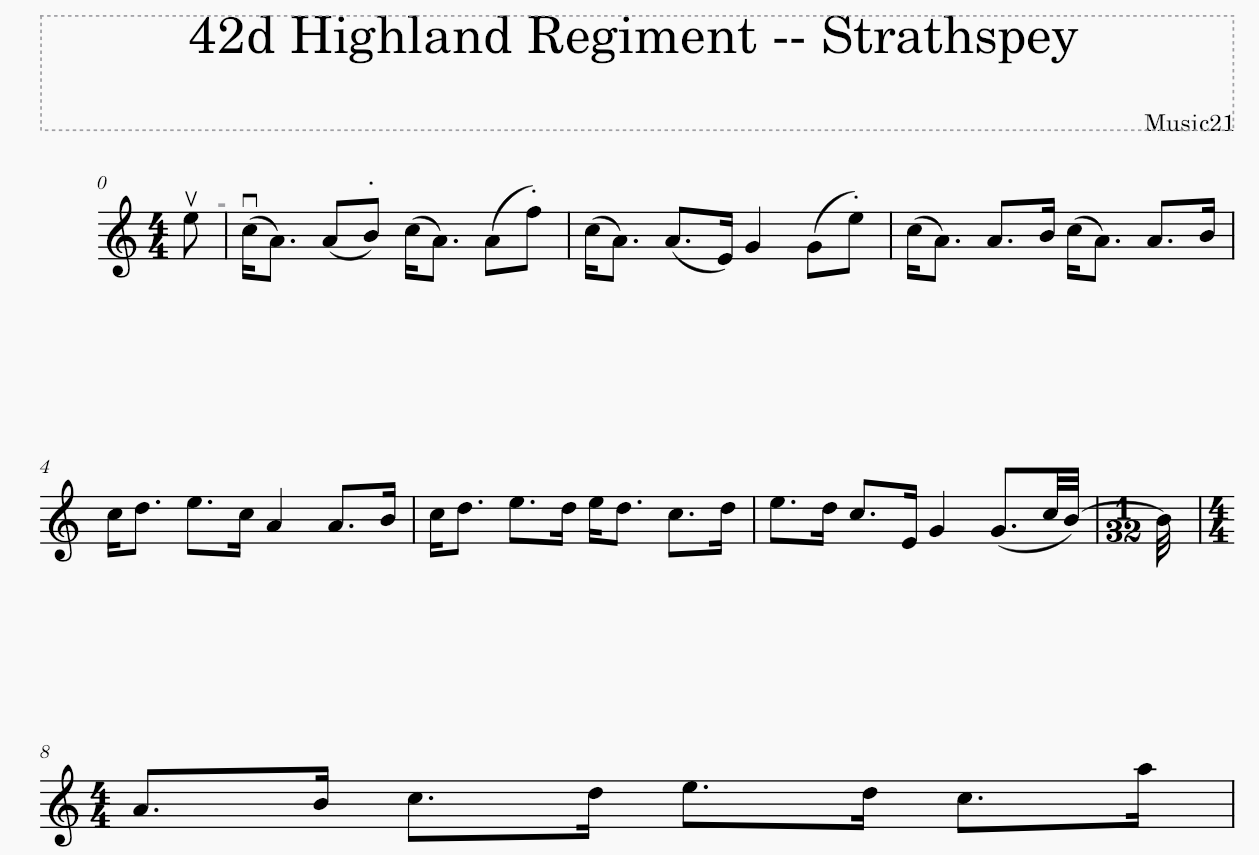

Let’s take our knowledge of spanners and see if **the last note of a slur** is generally higher or lower than the first note.

In [7]:
# We’ll use a RecursiveIterator with a ClassFilter of ‘Slur’ to find them all

highlandIterator = highlandParsed.recurse()
highlandSlurs = highlandIterator.getElementsByClass('Slur')

higher = 0
lower = 0
same = 0 # could happen for slurs longer than 2 notes

for sl in highlandSlurs:
    firstNote = sl.getFirst()
    lastNote = sl.getLast()
    psDiff = lastNote.pitch.ps - firstNote.pitch.ps
    if psDiff > 0:
        higher += 1
    elif psDiff < 0:
        lower += 1
    else:
        same += 1

In [8]:
(higher, lower, same)

(19, 30, 0)

Hmmm… it looks like of the 49 slurs in this piece, more of them end lower than higher.

Let’s do this on a sample of the first 20 pieces in the collection.

In [9]:
from statistics import mean
from collections import Counter

totalCounter = Counter()

def countOneSlur(sl, totalCounter):
    firstNote = sl.getFirst()
    lastNote = sl.getLast()
    if not hasattr(firstNote, 'pitches'):
        return
    if not hasattr(lastNote, 'pitches'):
        return

#in case a slur begins on a Chord, by taking the average pitch value of all the notes in the slur

    firstNotePs = mean(p.ps for p in firstNote.pitches)
    lastNotePs = mean(p.ps for p in lastNote.pitches)
    psDiff = lastNotePs - firstNotePs
    if psDiff > 0:
        totalCounter['higher'] += 1
    elif psDiff < 0:
        totalCounter['lower'] += 1
    else:
        totalCounter['same'] += 1

Now let’s make a function that takes in an object from ***corpus.search*** and parses it and runs each slur through ***countOneSlur***

In [10]:
def runOneScore(scCorpusSearchObject, totalCounter):
    scParsed = scCorpusSearchObject.parse()
    for sl in scParsed.recurse().getElementsByClass('Slur'):
        countOneSlur(sl, totalCounter)

Always important to **test** to make sure we haven’t broken anything.

In [11]:
runOneScore(highland[0], totalCounter)

In [12]:
totalCounter

Counter({'lower': 30, 'higher': 19})

 Let’s reset our counter and run the first 20 pieces through the process

In [13]:
totalCounter = Counter()

stop = 20
for piece in ryans:
    runOneScore(piece, totalCounter)
    stop = stop - 1
    if stop == 0:
        break

In [14]:
totalCounter

Counter({'lower': 69, 'higher': 73, 'same': 11})

Hmmm… this still shows a few more “lower” cases than “higher” but not very much of a difference.

If we run the whole data set(Simply remove the “stop” and “break” variables from above),  the results will come back in a minute or two.

In [16]:
# I did't ran it, I got these results from the author.
Counter({'higher': 3321, 'lower': 3637, 'same': 425})

Counter({'higher': 3321, 'lower': 3637, 'same': 425})

also about 10% more times that a slur ends below the first note than above

that’s the same ratio as we saw for the first ten pieces, but it might be quite **statistically significant** given the much larger dataset.

## Roman Numeral Analysis on a Melody

Let’s take a tune from a reel called "The Boston"

In [17]:
bostonMD = ryans.search('The Boston -- Reel')
bostonMD

<music21.metadata.bundles.MetadataBundle {1 entry}>

In [20]:
boston = bostonMD[0].parse()
boston.measures(0, 9).show('xml')

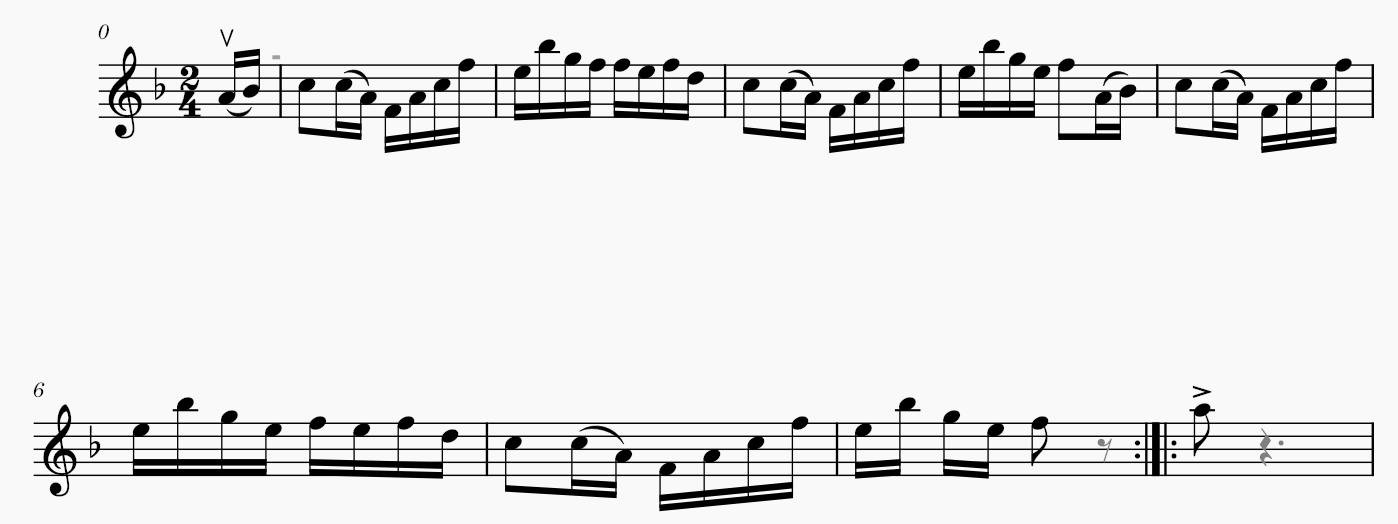

Now let’s create a chord from each beat in the piece (skipping the pickup notes), aggregating all the pitches from within that beat.

In [21]:
#  create a new Part object that has the same framework of Measures as the original, but no notes.
bostonPart = boston.parts[0]

# use the .template() method but tell it not to fill it with rests
outPart = bostonPart.template(fillWithRests=False)

Like we’ve done before, we’ll start from the smallest part and work outwards. 

In [22]:
# we’ll have to know what key we are in
pieceKey = boston.analyze('key')
pieceKey

<music21.key.Key of F major>

let’s make a routine that turns a list of Notes into a **RomanNumeral object**:

In [23]:
def notesToRoman(notes):
    uniquePitches = set(n.pitch for n in notes)
    ch = chord.Chord(list(uniquePitches))
    return roman.romanNumeralFromChord(ch, pieceKey)

Let’s test it with the notes of measure 1:

In [24]:
noteIterator = bostonPart.measure(1).notes
rn1 = notesToRoman(noteIterator)
rn1

<music21.roman.RomanNumeral I in F major>

Great, this is exactly what we’re looking for. Now let’s go into each measure that is full and **analyze it separately**.

We’ll get everything from offset 0 to 1, then 1 to 2:

In [25]:
inMeasures = list(bostonPart[stream.Measure])
outMeasures = list(outPart[stream.Measure])

for i in range(14):
    inMeasure = inMeasures[i]
    if inMeasure.duration.quarterLength != 2.0:
        continue
    outMeasure = outMeasures[i]

    for beatStart in (0, 1):
        beatNotes = inMeasure.getElementsByOffset(beatStart,
                                                  beatStart + 1,
                                                  includeEndBoundary=False
                                                 ).getElementsByClass(note.NotRest)
        beatRN = notesToRoman(beatNotes)
        beatRN.lyric = beatRN.figure
        outMeasure.insert(beatStart, beatRN)

In [26]:
outPart.show('xml')

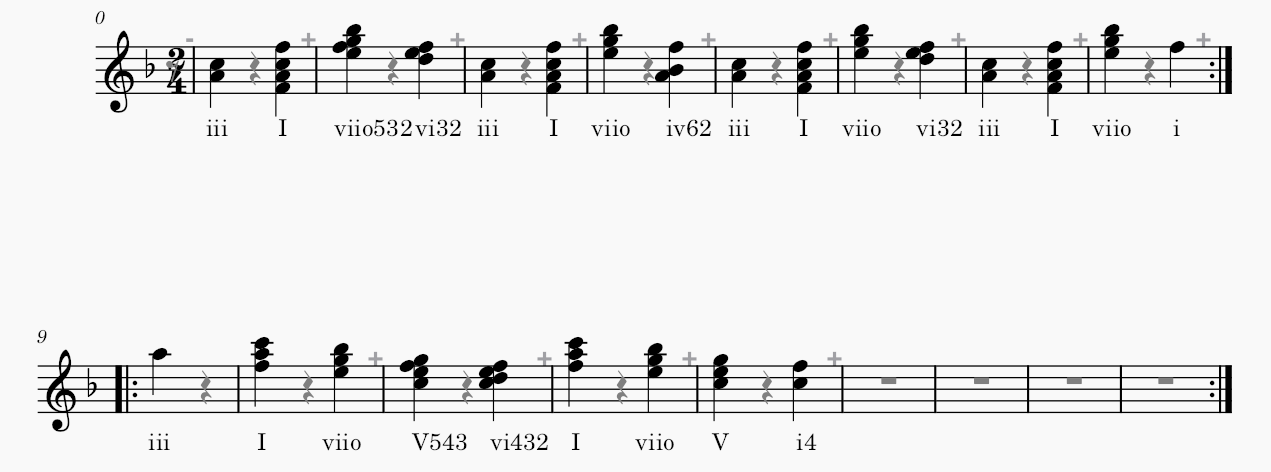

Analyzing something about RomanNumber is too complicated for me, so I just omit the following elements.

As I mentioned before, the important thing is that you could do sth with your own repertory !!!